# One-step Ignition Mechanism for n-heptane/air Combustion

_Highlights_
- Building a simple mechanism from Python with Cantera
- Comparing n-heptane ignition behavior for two reaction mechanisms

## Introduction

This demonstration shows how to build a reaction mechanism, here a simple one-step global combustion reaction for n-heptane, using Cantera. We then use Spitfire to simulate homogeneous ignition of an h-heptane/air mixture, with both the one-step reaction mechanism and a kinetics model from Liu et al. (*Effects on Strain Rate on High-Pressure Nonpremixed N-Heptane Autoignition in Counterflow*, Comb. Flame, 137, 320-339, 2004.).

In [73]:
from spitfire import ChemicalMechanismSpec, HomogeneousReactor
import cantera as ct
import matplotlib.pyplot as plt

## Building the Mechanism


### Specifying the Reaction
Cantera provides several formats for chemical reaction mechanism - see [here](https://cantera.org/tutorials/input-files.html) for the details. We use the CTI format below to create the following reaction and its non-elementary rate expression. A standard Arrhenius rate constant is employed.

$$
2\mathrm{C}_7\mathrm{H}_{16} \, + 22\mathrm{O}_2 \, \rightarrow 14\mathrm{CO}_2 \, + 16\mathrm{H}_2\mathrm{O}
$$

$$
\mathrm{rate} = 2\cdot10^{7}\exp\left(-\frac{30 \mathrm{kcal}/\mathrm{mol}}{RT}\right)\langle\mathrm{C}_7\mathrm{H}_{16}\rangle^{0.25}\langle\mathrm{O}_2\rangle^{1.5}
$$

An advantage to building this mechanism in Python is that we could easily test a range of parameters such as the activation energy or pre-exponential factor. We could even build a reactor into an optimization loop to identify an optimal one-step reaction rate in some sense.

In [74]:
reaction_cti = '''
reaction(
'2 NXC7H16 + 22 O2 => 14 CO2 + 16 H2O', 
[2e7, 0, (30.0, 'kcal/mol')], 
order='NXC7H16:0.25 O2:1.5')
'''

### Specifying Species Properties

Now we need to specify thermodynamic properties - molecular weights and heat capacity polynomials over temperature. We obtain these from the Liu et al. mechanism. Below we build the `species_list` to contain the Cantera `Species` objects  required for the one-step mechanism.

In [79]:
species_in_model = ['NXC7H16', 'O2', 'H2O', 'CO2', 'N2']

liu_xml_file = 'heptane-liu-hewson-chen-pitsch-highT.xml'
species_data = ct.Species.listFromFile(liu_xml_file)

species_list = list()
for sp in species_data:
    if sp.name in species_in_model:
        species_list.append(sp)

### Combine for a Cantera `Solution`

Now the final step - build a Cantera `Solution` that includes the listed species and the reaction(s) defined above.

In [81]:
s = ct.Solution(thermo='IdealGas',
                kinetics='GasKinetics',
                species=species_list,
                reactions=[ct.Reaction.fromCti(reaction_cti)])

## Comparing Ignition Behavior

Now we create Spitfire `ChemicalMechanismSpec` objects, which can be done with the `Solution` object as follows, or with the XML as we've done before (which we use below to build the Liu mechanism holder).

Given the mechanisms, we can now build `HomogeneousReactor` instances filled with stoichiometric n-heptane/air mixtures, and integrate them for 100 ms, which will encompass an ignition event from a sparked mixture at 1000 K and atmospheric pressure. Major species and temperature are plotted over time in the following figures.

In [83]:
mech_1step = ChemicalMechanismSpec.from_solution(s)
mech_liu = ChemicalMechanismSpec(cantera_xml=xml_file_for_species, group_name='gas')

solutions = dict()

for mech, name in [(mech_1step, '1 step'), 
                   (mech_liu, 'Liu')]:
    
    fuel = mech.stream('X', 'NXC7H16:1')
    air = mech.stream(stp_air=True)

    mix = mech.mix_for_equivalence_ratio(phi=1., fuel=fuel, oxy=air)
    mix.TP = 1000, 101325

    reactor = HomogeneousReactor(mech_spec=mech,
                                 initial_mixture=mix,
                                 configuration='isobaric',
                                 heat_transfer='adiabatic',
                                 mass_transfer='closed')

    solutions[name] = reactor.integrate_to_time(0.1)

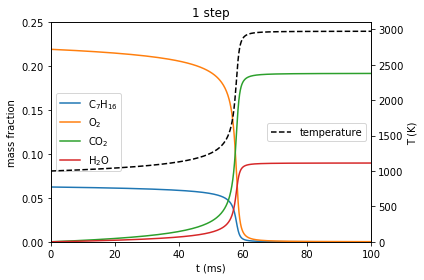

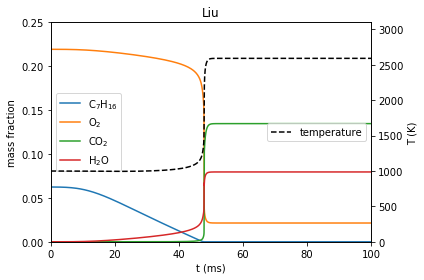

In [86]:
for name in solutions:
    solution = solutions[name]
    t = solution.time_values * 1.e3

    fig, axY = plt.subplots()

    axY.plot(t, solution['mass fraction NXC7H16'], label='$\\mathrm{C}_7\\mathrm{H}_{16}$')
    axY.plot(t, solution['mass fraction O2'], label='$\\mathrm{O}_2$')
    axY.plot(t, solution['mass fraction CO2'], label='$\\mathrm{CO}_2$')
    axY.plot(t, solution['mass fraction H2O'], label='$\\mathrm{H}_2\\mathrm{O}$')
    axY.legend(loc='center left')
    axY.set_ylabel('mass fraction')
    axY.set_xlim([0, 100])
    axY.set_ylim([0, 0.25])
    axY.set_xlabel('t (ms)')

    axT = axY.twinx()
    axT.plot(t, solution['temperature'], 'k--', label='temperature')
    axT.set_ylabel('T (K)')
    axT.set_ylim([0, 3100])
    axT.legend(loc='center right')

    plt.title(name)
    fig.tight_layout()
    plt.show()

The plots above suggest several key differences between the one-step and more detailed reaction mechanisms.

- The one-step mechanism predicts that the ignited mixture is hotter (~400 K) and contains more CO2. The simplified chemistry represents idealized combustion, with all hydrogen going to H2O and all carbon going to CO2.
- The more detailed mechanism predicts breakdown of the n-heptane in the fuel during the induction phase.

The following plot shows the Liu et al. results, this time including the ethylene (C2H4) and carbon monoxide (CO) mass fractions to show the breakdown of n-heptane into smaller hydrocarbons and to make up the difference in CO2 prediction from the one-step model.

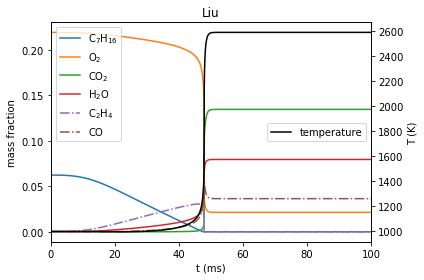

In [87]:
solution = solutions['Liu']
t = solution.time_values * 1.e3

fig, axY = plt.subplots()

axY.plot(t, solution['mass fraction NXC7H16'], label='$\\mathrm{C}_7\\mathrm{H}_{16}$')
axY.plot(t, solution['mass fraction O2'], label='$\\mathrm{O}_2$')
axY.plot(t, solution['mass fraction CO2'], label='$\\mathrm{CO}_2$')
axY.plot(t, solution['mass fraction H2O'], label='$\\mathrm{H}_2\\mathrm{O}$')
axY.plot(t, solution['mass fraction C2H4'], '-.', label='$\\mathrm{C}_2\\mathrm{H}_4$')
axY.plot(t, solution['mass fraction CO'], '-.', label='$\\mathrm{CO}$')
axY.legend(loc='upper left')
axY.set_ylabel('mass fraction')
axY.set_xlim([0, 100])
axY.set_xlabel('t (ms)')

axT = axY.twinx()
axT.plot(t, solution['temperature'], 'k-', label='temperature')
axT.set_ylabel('T (K)')
axT.legend(loc='center right')

plt.title(name)
fig.tight_layout()
plt.show()

## Conclusions

This notebook has briefly showcased the use of Cantera to build reaction mechanisms from Python, and the use of Spitfire to compare ignition behavior of two n-heptane combustion mechanisms.